In [32]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
from lmfit import Parameters
import pandas as pd

In [33]:
# load data
base = pd.read_csv('base_data.csv')
high_noise = pd.read_csv('hign_noise_data.csv')
more_components = pd.read_csv('more_components_data.csv')

# define fixed position
true_centers = {
        1: [1650],
        2: [1450, 1650],
        3: [1500, 1600, 1700],
        4: [1450, 1550, 1650, 1750],
        5: [1450, 1550, 1600, 1650, 1750], 
        6: [1400, 1500, 1550, 1650, 1700, 1800]
    }


In [60]:
def create_model(centers):
    model = None
    params = Parameters()
    
    for i, center in enumerate(centers):
        prefix = f'g{i}_'
        gauss = GaussianModel(prefix=prefix)
        
        if model is None:
            model = gauss
        else:
            model += gauss
        
        params.add(prefix+'center', value=center, vary=False)
        params.add(prefix+'amplitude', value=100, min=0.1, max=1e5)
        params.add(prefix+'sigma', value=50, min=5, max=200)
        
    return model, params

# AICc & BIC
def calculate_metrics(result, n_params, data_length):
    if result is None or not result.success:
        return {'AICc': np.nan, 'BIC': np.nan}
    
    k = n_params 
    n = data_length
    rss = result.chisqr
    sigma_sq = rss / n 
    log_like = -0.5 * n * (np.log(2 * np.pi * sigma_sq) + 1)

    aic = 2*k - 2*log_like
    bic = k*np.log(n) - 2*log_like
    aicc = aic + (2*k*(k+1))/(n-k-1) if (n-k-1) > 0 else aic
    
    return {'AICc': aicc, 'BIC': bic}

# DIC
def compute_deviance(model, params, x, y, sigma):
    best_fit = model.eval(params, x=x)
    residuals = (y - best_fit) / sigma
    log_likelihood = -0.5 * np.sum(residuals**2)
    return -2 * log_likelihood 

def compute_DIC_bootstrap(model, result, x, y, sigma, n_samples=500):
    D_values = []
    best_fit = model.eval(result.params, x=x)
    residuals = y - best_fit

    for _ in range(n_samples):
        resampled_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
        y_resampled = best_fit + resampled_residuals
        res_residuals = (y_resampled - best_fit) / sigma
        logL = -0.5 * np.sum(res_residuals**2)
        D_values.append(-2 * logL)

    D_mean = np.mean(D_values)
    D_best = compute_deviance(model, result.params, x, y, sigma)
    p_D = D_mean - D_best
    DIC = D_mean + p_D
    return DIC


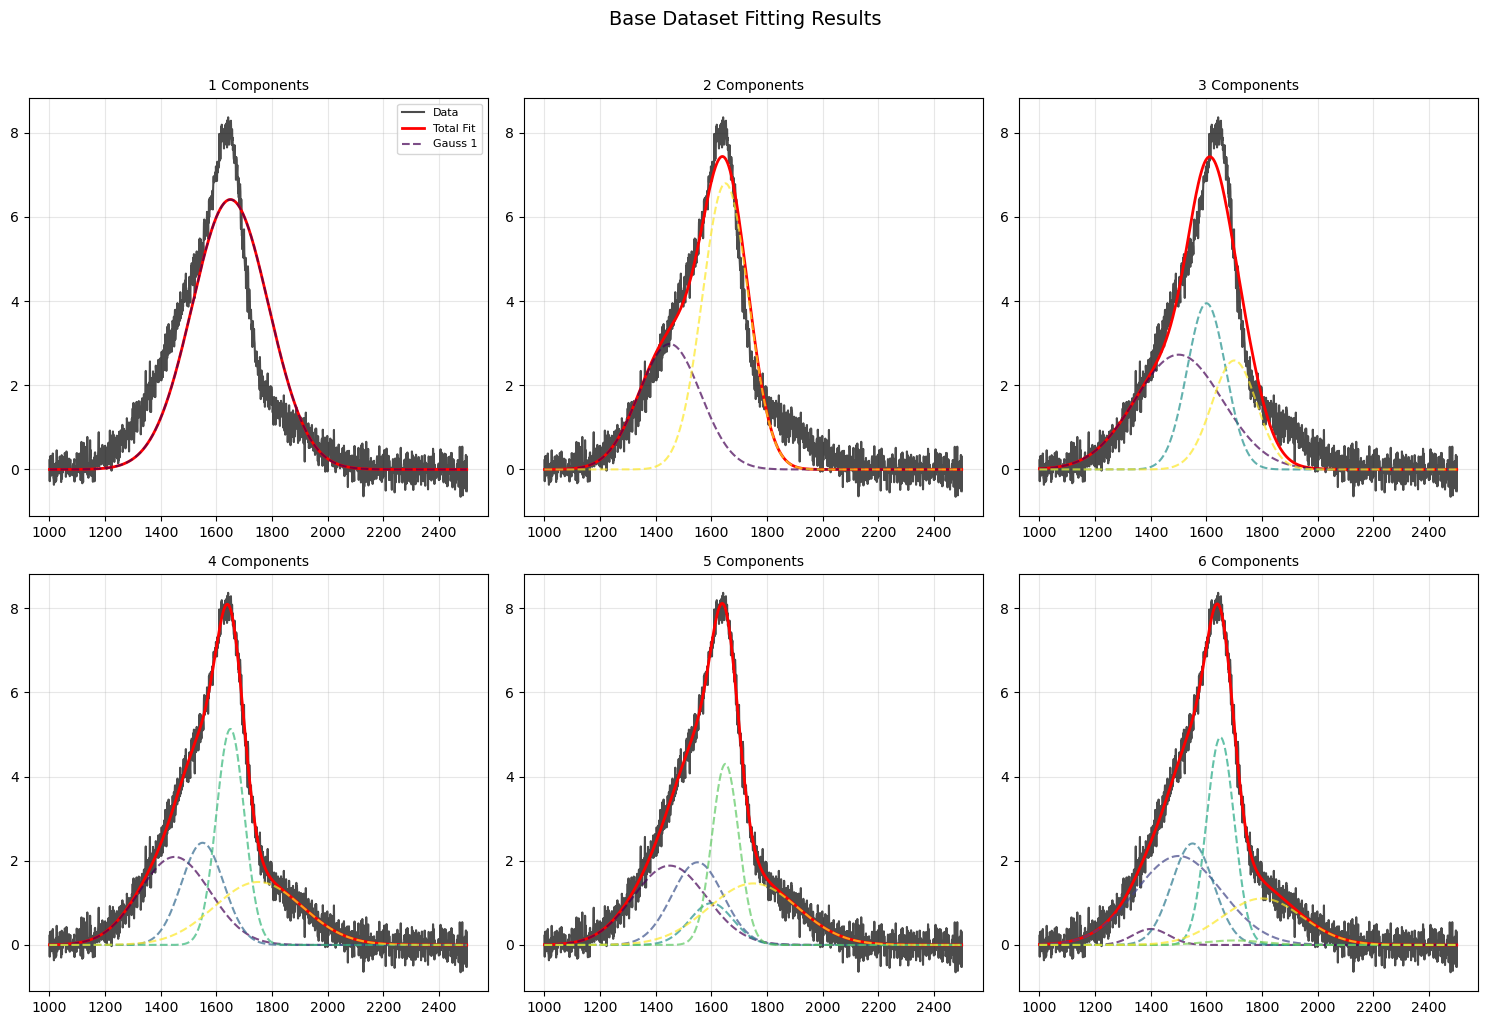


=== Base Dataset ===
 Components   AICc   ΔAICc    BIC    ΔBIC    DIC  ΔDIC
          1 3864.0     0.0 3874.6     0.0 1492.8   0.0
          2 1857.4 -2006.6 1878.6 -1996.0 1493.4   0.5
          3 1796.1 -2067.9 1827.9 -2046.7 1497.3   4.5
          4 -163.2 -4027.2 -120.8 -3995.4 1489.9  -2.9
          5 -165.2 -4029.2 -112.2 -3986.8 1486.6  -6.2
          6 -162.5 -4026.5  -98.9 -3973.5 1491.1  -1.7


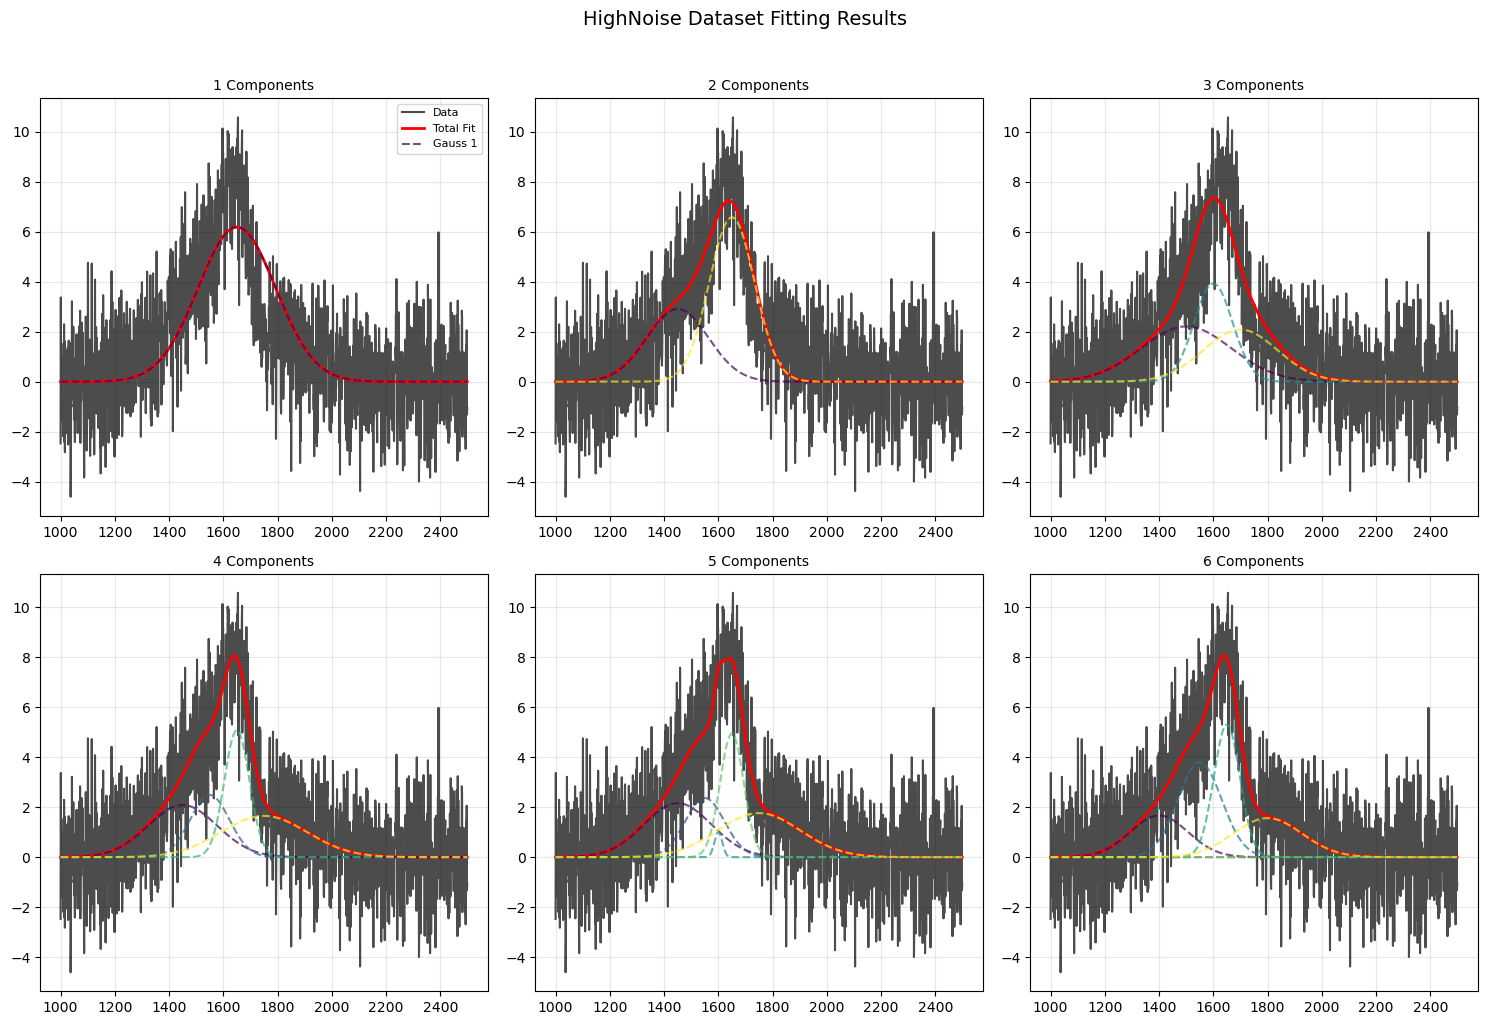


=== HighNoise Dataset ===
 Components   AICc  ΔAICc    BIC   ΔBIC    DIC  ΔDIC
          1 6001.8    0.0 6012.4    0.0 1502.4   0.0
          2 5748.1 -253.7 5769.3 -243.1 1502.8   0.3
          3 5728.9 -272.9 5760.8 -251.6 1490.7 -11.7
          4 5636.6 -365.2 5679.0 -333.4 1486.9 -15.5
          5 5634.6 -367.2 5687.6 -324.8 1484.7 -17.7
          6 5642.9 -358.9 5706.5 -305.9 1488.5 -13.9


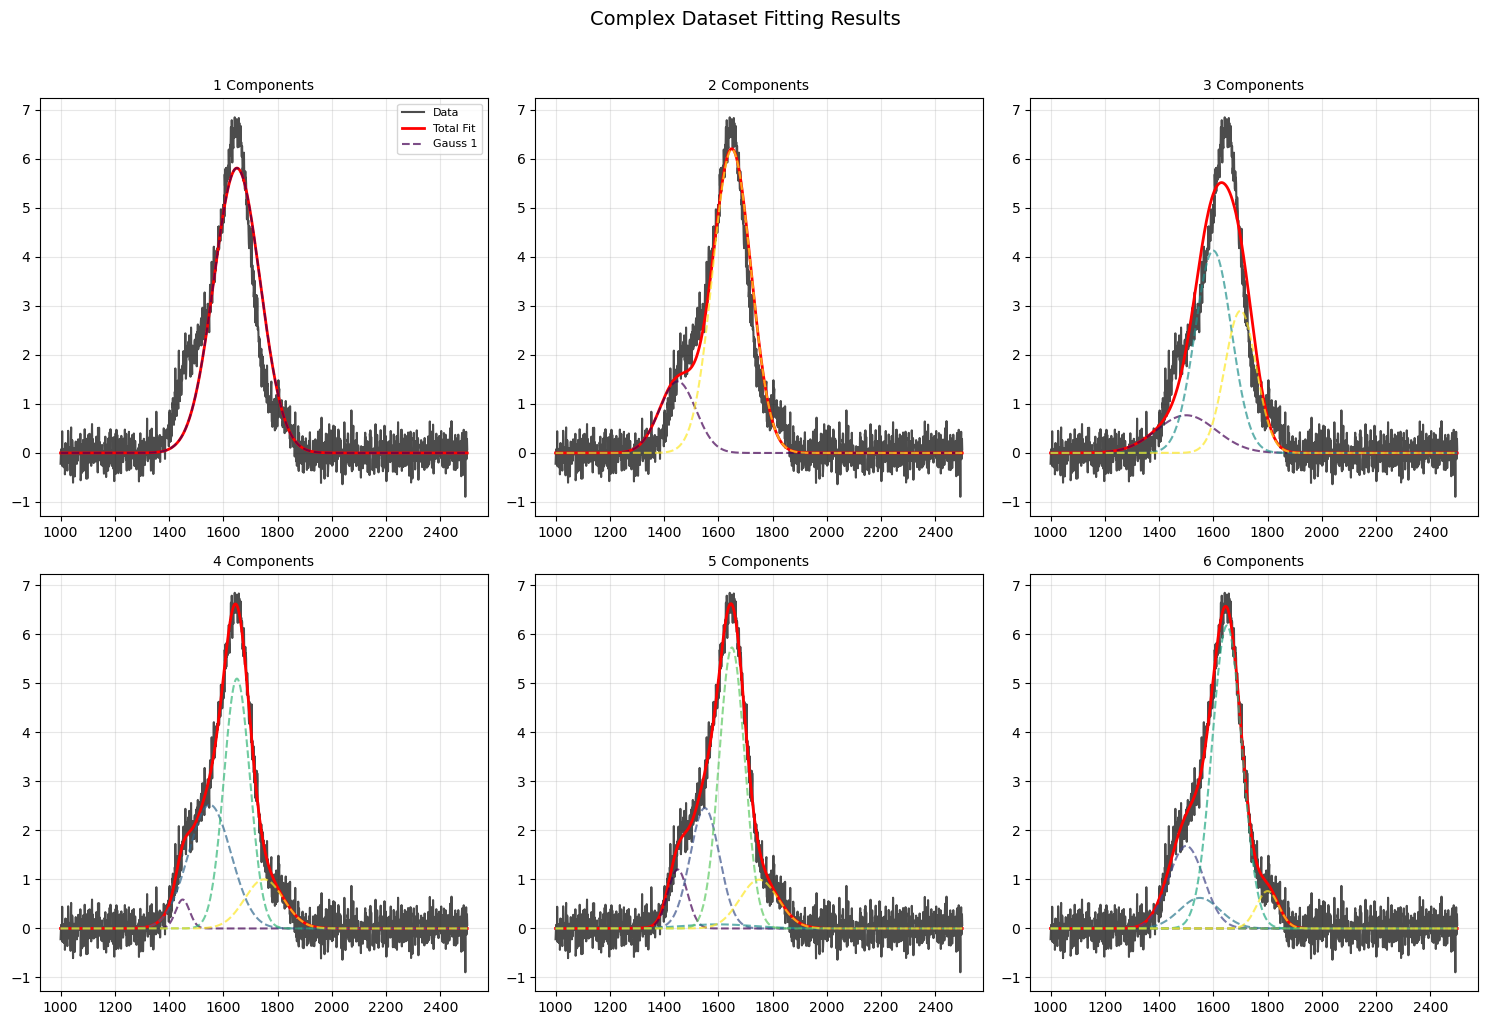


=== Complex Dataset ===
 Components   AICc   ΔAICc    BIC    ΔBIC    DIC  ΔDIC
          1 2209.3     0.0 2219.9     0.0 1495.8   0.0
          2 1170.0 -1039.2 1191.2 -1028.6 1502.1   6.4
          3 1592.1  -617.2 1623.9  -596.0 1496.5   0.8
          4   61.4 -2147.9  103.8 -2116.1 1493.5  -2.2
          5   56.9 -2152.3  109.9 -2110.0 1489.6  -6.2
          6   67.9 -2141.4  131.4 -2088.5 1483.4 -12.4


In [61]:
# model fitting
results = {}

for name, df in [('Base', base), 
                ('HighNoise', high_noise),
                ('Complex', more_components)]:
    x = df.Wavelength.values
    y = df.Flux.values
    
    criterion_df = pd.DataFrame()
    
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'{name} Dataset Fitting Results', fontsize=14, y=1.02)
    
    for n in range(1, 7):
        centers = true_centers[n]
        model, params = create_model(centers)
        result = model.fit(y, params, x=x)

        # AIC & BIC 
        metrics = calculate_metrics(result, 2*n, len(y))
        
        # DIC
        #sigma = np.std(y - result.best_fit)
        #sigma = np.sqrt(result.chisqr / (len(y) - 2*n)) 
        estimated_sigma = np.sqrt(result.chisqr / (len(y) - 2*n))
        sigma = max(estimated_sigma, 0.1 * np.std(y))  # avoid very small sigma
        DIC_value = compute_DIC_bootstrap(model, result, x, y, sigma)

        new_row = pd.DataFrame({
            'Components': [n],
            'AICc': [metrics['AICc']],
            'BIC': [metrics['BIC']],
            'DIC': [DIC_value]
        })
        criterion_df = pd.concat([criterion_df, new_row], ignore_index=True)
        
        # plot result
        ax = plt.subplot(2, 3, n)
        ax.plot(x, y, 'k-', alpha=0.7, label='Data')
        
        ax.plot(x, result.best_fit, 'r-', lw=2, label='Total Fit')
        
        # components
        colors = plt.cm.viridis(np.linspace(0, 1, n))
        for i in range(n):
            comp = result.eval_components(x=x)[f'g{i}_']
            ax.plot(x, comp, '--', color=colors[i], 
                   alpha=0.7, label=f'Gauss {i+1}')
        
        ax.set_title(f'{n} Components', fontsize=10)
        ax.grid(alpha=0.3)
        if n == 1:
            ax.legend(loc='upper right', fontsize=8)
    
    base_row = criterion_df[criterion_df['Components'] == 1].iloc[0]
    base_aicc = base_row['AICc']
    base_bic = base_row['BIC']
    base_dic = base_row['DIC']
    criterion_df['ΔAICc'] = criterion_df['AICc'] - base_aicc
    criterion_df['ΔBIC'] = criterion_df['BIC'] - base_bic
    criterion_df['ΔDIC'] = criterion_df['DIC'] - base_dic
    criterion_df = criterion_df[['Components', 'AICc', 'ΔAICc', 'BIC', 'ΔBIC', 'DIC', 'ΔDIC']]

    results[name] = criterion_df
    plt.tight_layout()
    plt.show()
    
    # print result
    print(f'\n=== {name} Dataset ===')
    print(criterion_df.to_string(index=False, float_format="%.1f"))

    